In [1]:
import numpy as np
import pandas as pd

In [2]:
all_utterances = pd.read_csv('utterances.csv').set_index('id')

In [3]:
all_advocates = pd.read_excel('advocates.xlsx').set_index('id')

In [34]:
all_convos = pd.read_excel('all_convos.xlsx').set_index('id').dropna()
all_convos['meta.advocates'] = all_convos['meta.advocates'].apply(eval)
all_convos['meta.votes_side'] = all_convos['meta.votes_side'].apply(eval)

## Chunks

In [246]:
def get_chunks_from_utterances(convo_id, convo_utts):
  chunks = []
  
  chunk_no = 0
  chunk_start = 0
  
  cur_chunk = []
  cur_advocate = None
  cur_justice = None

  while chunk_start < len(convo_utts):
    # greedily extract chunk
    speaker = convo_utts.iloc[chunk_start]['speaker']
    speaker_type = convo_utts.iloc[chunk_start]['meta.speaker_type']
    
    if speaker_type != 'A':
      # chunks should begin with an advocate speaking
      chunk_start += 1
      continue
    
    # otherwise, begin a new chunk
    cur_advocate = speaker

    chunk_end = chunk_start
    while chunk_end < len(convo_utts):
      utt_id = convo_utts.utterance_id[chunk_end]
      
      speaker2 = convo_utts.iloc[chunk_end]['speaker']
      speaker2_type = convo_utts.iloc[chunk_end]['meta.speaker_type']

      if speaker2_type not in ['A', 'J']:
        # ex. <INAUDIBLE>
        break
      elif speaker2_type == 'A' and speaker2 != cur_advocate:
        # chunks should have only 1 advocate
        break
      elif speaker2_type == 'J' and speaker2 != cur_justice:
        if cur_justice is not None:
          # chunks should have only 1 justice
          break
        else:
          # this is the first time we've encountered a new justice
          cur_justice = speaker2

      cur_chunk.append(utt_id)
      chunk_end += 1
    
    if len(cur_chunk) >= 4 and cur_advocate is not None and cur_justice is not None:
      # chunks must have at least 4 utterances
      chunk_df = pd.DataFrame(dict(
        conversation_id=convo_id,
        chunk_no=chunk_no,
        utterance_id=cur_chunk,
        advocate_id=cur_advocate,
        justice_id=cur_justice
      ))

      merged = chunk_df.merge(convo_utts, on='utterance_id')
      chunk_df['speaker_type'] = merged['meta.speaker_type']
      chunk_df['interrupted'] = merged.text.str[-2:].isin(['..', '--'])
      # a token is matched by the following regex, which matches words (allowing apostrophes) and floating point numbers.
      chunk_df['n_tokens'] = merged.text.str.count(r"([A-Za-z]+('[A-Za-z]+)?)|([-]?([0-9]*[.])?[0-9]+)")

      chunks.append(chunk_df)
      # allow the next chunk to start using the end of this chunk
      chunk_start = chunk_end - 1 
      chunk_no += 1
    else:
      # try to start a chunk at the next utterance
      chunk_start += 1
    
    cur_chunk = []
    cur_advocate = None
    cur_justice = None
  
  if len(chunks) > 0:
    return pd.concat(chunks)
  else:
    return None

In [253]:
from IPython.display import clear_output
dfs = []
i = 0
is_convo_post_1982 = all_convos['meta.case_id'].apply(lambda id: int(id.split('_')[0])) >= 1982

for convo_id in all_convos[is_convo_post_1982].index:
  if i % 100 == 0:
    clear_output()
    print(i, '/', is_convo_post_1982.sum())
  i += 1
  convo_utts = all_utterances.query('conversation_id == @convo_id') \
    .reset_index() \
    .rename(columns={'id': 'utterance_id'})
  if (chunks := get_chunks_from_utterances(convo_id, convo_utts)) is not None:
    dfs.append(chunks)

clear_output()
print('Done.')

chunks = pd.concat(dfs)

Done.


In [254]:
chunks.to_csv('/flatfiles/chunks_v2.csv')

In [256]:
chunks

,conversation_id,chunk_no,utterance_id,advocate_id,justice_id,speaker_type,interrupted,n_tokens
0,18242,0,18242__0_003,alan_g_segedy,j__sandra_day_oconnor,A,True,518
1,18242,0,18242__0_004,alan_g_segedy,j__sandra_day_oconnor,J,False,19
2,18242,0,18242__0_005,alan_g_segedy,j__sandra_day_oconnor,A,False,4
3,18242,0,18242__0_006,alan_g_segedy,j__sandra_day_oconnor,J,False,3
4,18242,0,18242__0_007,alan_g_segedy,j__sandra_day_oconnor,A,True,6
...,...,...,...,...,...,...,...,...
6,24969,17,24969__2_006,eric_j_feigin,j__sonia_sotomayor,A,False,3
7,24969,17,24969__2_007,eric_j_feigin,j__sonia_sotomayor,J,True,25
8,24969,17,24969__2_008,eric_j_feigin,j__sonia_sotomayor,A,True,3
9,24969,17,24969__2_009,eric_j_feigin,j__sonia_sotomayor,J,False,1


## Interruptions

In [258]:
interruptions = chunks.query('speaker_type == "A"').groupby(['conversation_id', 'chunk_no', 'advocate_id', 'justice_id']).sum()

In [267]:
interruption_rate = interruptions.interrupted / (interruptions.n_tokens / 1000)
interruption_rate.name = 'interruption_rate'

In [268]:
interruption_rate.reset_index().to_csv('flatfiles/interruptions.csv', header=True, index=False)

## Genders

In [441]:
from nameparser import HumanName

advocate_names = all_advocates.rename(columns={'meta.name': 'name'})[['name']]
advocate_names['lastname'] = advocate_names['name'].apply(lambda n: HumanName(n).last)
advocate_names['male_honorific'] = 'Mr. ' + advocate_names['lastname']
advocate_names['female_honorific'] = 'Ms. ' + advocate_names['lastname']

In [442]:
is_convo_post_1982 = all_convos['meta.case_id'].apply(lambda id: int(id.split('_')[0])) >= 1982

In [443]:
advocates_per_convo = all_convos.loc[is_convo_post_1982, 'meta.advocates'].apply(lambda a: a.keys()) \
  .explode() \
  .replace('', None) \
  .dropna() \
  .reset_index() \
  .rename(columns={'id': 'conversation_id', 'meta.advocates': 'advocate_id'})

In [444]:
honorific_utt = all_utterances[all_utterances.speaker.str.contains('j__')].copy().set_index('conversation_id')['text'].str.findall(r'(Mr. \w+|Ms. \w+)')
honorific_utt.name = 'j_honorifics_uttered'

In [445]:
# left merge??
honorifics_uttered = advocates_per_convo.merge(honorific_utt.groupby(level=0).sum().reset_index(), on='conversation_id') \
  .groupby('advocate_id')['j_honorifics_uttered'].sum().apply(set)

In [459]:
names_and_honorifics = advocate_names.join(honorifics_uttered)

In [460]:
names_and_honorifics['matched_mr'] = names_and_honorifics.apply(
  lambda a: a['male_honorific'] in a['j_honorifics_uttered'] 
    if type(a['j_honorifics_uttered']) == set else False, 
  axis=1
)
names_and_honorifics['matched_ms'] = names_and_honorifics.apply(
  lambda a: a['female_honorific'] in a['j_honorifics_uttered']
    if type(a['j_honorifics_uttered']) == set else False, 
  axis=1
)

In [461]:
one_honorific_matched = names_and_honorifics['matched_mr'] ^ names_and_honorifics['matched_ms']
names_and_honorifics['gender'] = np.where(one_honorific_matched, names_and_honorifics['matched_ms'], None) # female = True, male = False

In [476]:
from gender_guesser.detector import Detector as GenderDetector
detector = GenderDetector()
names_and_honorifics['firstname'] = names_and_honorifics['name'].apply(lambda n: HumanName(n).first)
names_and_honorifics['gender_det'] = names_and_honorifics['firstname'].apply(detector.get_gender)

In [485]:
print(((names_and_honorifics.gender == False) & (names_and_honorifics.gender_det == "female")).sum(), 'males detected as female.')
print(((names_and_honorifics.gender == True) & (names_and_honorifics.gender_det == "male")).sum(), 'females detected as male.')

17 males detected as female.
8 females detected as male.


In [495]:
print(
  'Confident detector for', 
  (names_and_honorifics.gender.isna() & names_and_honorifics.gender_det.isin(['male', 'female'])).sum(), 
  '/', 
  names_and_honorifics.gender.isna().sum(), 
  'unmatched genders.'
)
print((names_and_honorifics.gender.isna() & names_and_honorifics.gender_det.isin(['female'])).sum(), 'are female.')

Confident detector for 4257 / 4974 unmatched genders.
214 are female.


In [496]:
# set confident detected genders
names_and_honorifics.loc[names_and_honorifics.gender.isna() & (names_and_honorifics.gender_det == 'male'), 'gender'] = False
names_and_honorifics.loc[names_and_honorifics.gender.isna() & (names_and_honorifics.gender_det == 'female'), 'gender'] = True

In [499]:
# manually resolve those that are both mr and ms
names_and_honorifics.query('matched_mr & matched_ms & gender.isna()')

,name,lastname,male_honorific,female_honorific,j_honorifics_uttered,matched_mr,matched_ms,gender,gender_det,firstname
id,,,,,,,,,,
mary_s_burdick,Mary S. Burdick,Burdick,Mr. Burdick,Ms. Burdick,"{Ms. Burdick, Mr. Merrill, Mr. Burdick}",True,True,None,mostly_female,Mary
carolou_perry_durham,Carolou Perry Durham,Durham,Mr. Durham,Ms. Durham,"{Mr. Washko, Mr. Robbins, Ms. Durham, Mr. Durham}",True,True,None,unknown,Carolou
gale_norton,Gale Norton,Norton,Mr. Norton,Ms. Norton,"{Mr. Cook, Mr. Norton, Mr. O, Ms. Norton, Mr. ...",True,True,None,mostly_female,Gale
corbett_gordon,Corbett Gordon,Gordon,Mr. Gordon,Ms. Gordon,"{Mr. Kirkingburg, Mr. Dumont, Mr. Hunt, Ms. Go...",True,True,None,unknown,Corbett
j_bart_delone,J. Bart DeLone,DeLone,Mr. DeLone,Ms. DeLone,"{Mr. DeLone, Ms. DeLone, Mr. Smith, Mr. Krill}",True,True,None,unknown,J.


In [500]:
names_and_honorifics.loc[[
  'mary_s_burdick', 
  'gale_norton',
  'corbett_gordon'
]] = True

In [501]:
names_and_honorifics['gender'].to_csv('flatfiles/genders.csv')

## Alignment

In [6]:
interruptions = pd.read_csv('flatfiles/interruptions.csv')

In [85]:
votes = all_convos.reset_index().rename(columns={'id': 'conversation_id'}) \
  .merge(interruptions, on='conversation_id')

In [86]:
def do_align(r):
  try:
    return r['meta.advocates'][r.advocate_id]['side'] == r['meta.votes_side'][r.justice_id]
  except:
    return None

votes['do_align'] = votes.apply(do_align, axis=1)
print(votes.do_align.isna().sum(), 'conversation-advocate-justice triples do not match. Dropping.')
votes = votes.dropna().copy()

240 conversation-advocate-justice triples do not match. Dropping.


In [96]:
votes[interruptions.columns.to_list() + ['do_align']].to_csv('flatfiles/interruption_rates_and_alignment.csv', index=False, header=True)

## Experience

In [120]:
# is_convo_post_1982 = all_convos['meta.case_id'].apply(lambda id: int(id.split('_')[0])) >= 1982
advocates_per_convo = all_convos.loc[is_convo_post_1982, 'meta.advocates'].apply(lambda a: a.keys()) \
  .explode() \
  .replace('', None) \
  .dropna() \
  .reset_index() \
  .rename(columns={'id': 'conversation_id', 'meta.advocates': 'advocate_id'})

In [130]:
advocates_per_convo.groupby('advocate_id').count().rename(columns={'conversation_id': 'experience'}).to_csv('flatfiles/experience.csv', header=True, index=True)

## Analysis

In [138]:
genders = pd.read_csv('flatfiles/genders.csv').rename(columns={'id': 'advocate_id'})#.dropna()
experience = pd.read_csv('flatfiles/experience.csv')
interruptions = pd.read_csv('flatfiles/interruption_rates_and_alignment.csv').merge(genders).merge(experience)

In [139]:
n_advocates = len(interruptions.advocate_id.unique())
n_unmatched_advocates = len(interruptions[interruptions.gender.isna()].advocate_id.unique())
print(
  f'{interruptions.gender.isna().sum()} / {len(interruptions)} chunks',
  f'({n_unmatched_advocates} / {n_advocates} advocates corresponding to chunks) do not have a gender. Dropping.'
)
interruptions = interruptions.dropna()

229 / 78005 chunks (21 / 4053 advocates corresponding to chunks) do not have a gender. Dropping.


In [142]:
print('Most experienced advocates:')
experience.sort_values(by='experience', ascending=False).head(20)

Most experienced advocates:


,advocate_id,experience
1066,edwin_s_kneedler,139
2957,michael_r_dreeben,105
3136,paul_d_clement,103
2626,malcolm_l_stewart,88
468,carter_g_phillips,85
2473,lawrence_g_wallace,82
3854,seth_p_waxman,80
4084,theodore_b_olson,65
760,david_c_frederick,55
945,donald_b_verrilli_jr,54


In [106]:
print('Percent of chunks with a female advocate:')
interruptions.groupby('justice_id').gender.agg(['mean', 'count'])

Percent of chunks with a female advocate:


,mean,count
justice_id,,
j__anthony_m_kennedy,0.145153,6159
j__antonin_scalia,0.128633,12695
j__brett_m_kavanaugh,0.131234,381
j__byron_r_white,0.083670,5199
j__clarence_thomas,0.163265,49
j__david_h_souter,0.138889,4176
j__elena_kagan,0.148888,1753
j__harry_a_blackmun,0.130734,872
j__john_g_roberts_jr,0.160433,4251


In [147]:
print('Most experienced advocates:')
experience.merge(genders).query('gender == True').drop(columns='gender').sort_values(by='experience', ascending=False).head(20)

Most experienced advocates:


,advocate_id,experience
2403,lisa_s_blatt,39
2896,patricia_a_millett,32
2858,nicole_saharsky,29
290,beth_s_brinkmann,24
234,barbara_d_underwood,21
2649,maureen_e_mahoney,19
174,ann_oconnell,19
3580,sarah_e_harrington,19
233,barbara_b_mcdowell,18
1277,ginger_d_anders,17


In [148]:
print('Most frequent female advocates:')
interruptions.query('gender == True').groupby('advocate_id').interruption_rate.count().sort_values(ascending=False).head(20)

Most frequent female advocates:


advocate_id
beth_s_brinkmann       248
lisa_s_blatt           245
patricia_a_millett     245
maureen_e_mahoney      171
nicole_saharsky        160
barbara_d_underwood    156
deanne_e_maynard       137
pamela_s_karlan        133
barbara_b_mcdowell     127
sarah_e_harrington     127
kathleen_m_sullivan    116
ann_oconnell           108
amy_l_wax               98
rachel_p_kovner         89
leondra_r_kruger        84
kathryn_a_oberly        74
elaine_j_goldenberg     71
ginger_d_anders         70
katherine_p_baldwin     65
caitlin_j_halligan      54
Name: interruption_rate, dtype: int64

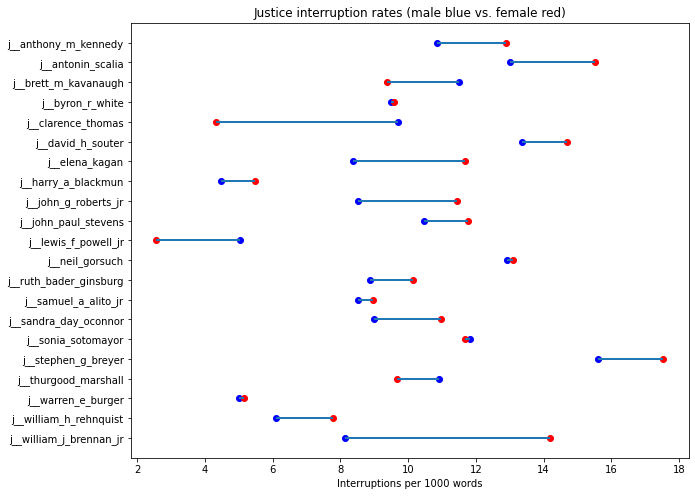

In [149]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

justice_interruption_rates = interruptions.groupby(['justice_id', 'gender']).interruption_rate.mean().unstack('gender').sort_index()

fig, ax = plt.subplots()
y_pos = np.arange(len(justice_interruption_rates))

lines = []
for i, j in enumerate(justice_interruption_rates.index):
  y = y_pos[i]
  xm = justice_interruption_rates.loc[j, False]
  xf = justice_interruption_rates.loc[j, True]
  plt.plot(xm, y, 'bo')
  plt.plot(xf, y, 'ro')
  lines.append([(xm, y), (xf, y)])
  
fig.set_size_inches(10, 8)
ax.add_collection(LineCollection(lines, linewidths=2))
ax.autoscale()

ax.set_yticks(y_pos, labels=justice_interruption_rates.index)
ax.invert_yaxis()
ax.set_xlabel('Interruptions per 1000 words')
ax.set_title('Justice interruption rates (male blue vs. female red)')

plt.show()

In [176]:
import statsmodels.api as sm

In [230]:
justices = interruptions.justice_id.sort_values().unique()
results = []
for justice in justices:
  y = interruptions.query('justice_id == @justice').interruption_rate
  X = interruptions.query('justice_id == @justice')[['gender', 'do_align', 'experience']].copy()
  X = sm.add_constant(X).replace({ False: 0, True: 1 })
  reg = sm.OLS(y, X).fit()
  conf_int = reg.conf_int(alpha=0.05, cols=None).stack()
  conf_int.index = conf_int.index.map('conf_{0[0]}_{0[1]}'.format)
  
  res = pd.concat([reg.params, conf_int])
  res['justice'] = justice

  results.append(res)
  
interruption_effects = pd.DataFrame(results).set_index('justice')

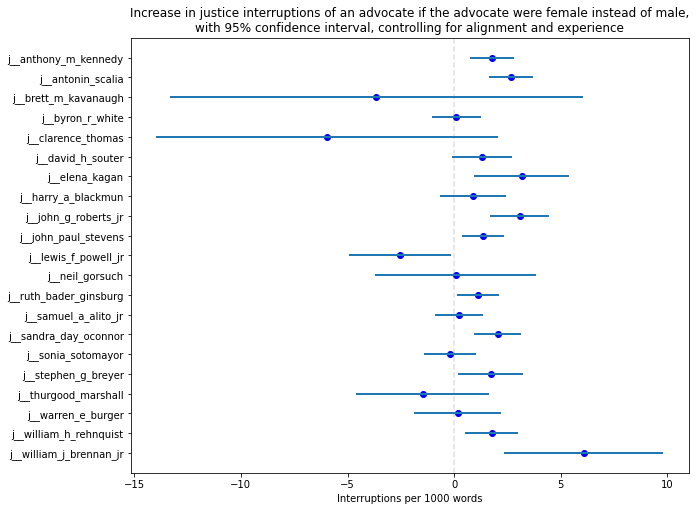

In [234]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

fig, ax = plt.subplots()
y_pos = np.arange(len(interruption_effects))

plt.axline((0, 0), (0, 1), color='gray', alpha=0.25, linestyle='dashed')

lines = []
for i, j in enumerate(interruption_effects.index):
  y = y_pos[i]
  x0 = interruption_effects.loc[j, 'conf_gender_0']
  x = interruption_effects.loc[j, 'gender']
  x1 = interruption_effects.loc[j, 'conf_gender_1']
  plt.plot(x, y, 'bo')
  lines.append([(x0, y), (x1, y)])

fig.set_size_inches(10, 8)
ax.add_collection(LineCollection(lines, linewidths=2))
ax.autoscale()

ax.set_yticks(y_pos, labels=justice_interruption_rates.index)
ax.invert_yaxis()
ax.set_xlabel('Interruptions per 1000 words')
ax.set_title(
  'Increase in justice interruptions of an advocate '
  'if the advocate were female instead of male,\n'
  'with 95% confidence interval, controlling for alignment and experience')

plt.show()

In [225]:
justices = interruptions.justice_id.sort_values().unique()
results = []
for justice in justices:
  y = interruptions.query('justice_id == @justice').interruption_rate
  X = interruptions.query('justice_id == @justice')[['gender']].copy()
  X = sm.add_constant(X).replace({ False: 0, True: 1 })
  reg = sm.OLS(y, X).fit()
  conf_int = reg.conf_int(alpha=0.05, cols=None).stack()
  conf_int.index = conf_int.index.map('conf_{0[0]}_{0[1]}'.format)
  
  res = pd.concat([reg.params, conf_int])
  res['justice'] = justice

  results.append(res)
  
interruption_effects = pd.DataFrame(results).set_index('justice')

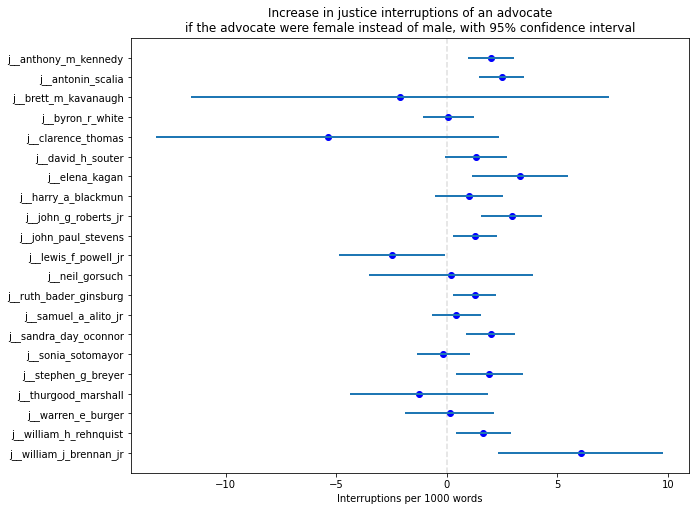

In [226]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

fig, ax = plt.subplots()
y_pos = np.arange(len(interruption_effects))

plt.axline((0, 0), (0, 1), color='gray', alpha=0.25, linestyle='dashed')

lines = []
for i, j in enumerate(interruption_effects.index):
  y = y_pos[i]
  x0 = interruption_effects.loc[j, 'conf_gender_0']
  x = interruption_effects.loc[j, 'gender']
  x1 = interruption_effects.loc[j, 'conf_gender_1']
  plt.plot(x, y, 'bo')
  lines.append([(x0, y), (x1, y)])

fig.set_size_inches(10, 8)
ax.add_collection(LineCollection(lines, linewidths=2))
ax.autoscale()

ax.set_yticks(y_pos, labels=justice_interruption_rates.index)
ax.invert_yaxis()
ax.set_xlabel('Interruptions per 1000 words')
ax.set_title('Increase in justice interruptions of an advocate\nif the advocate were female instead of male, with 95% confidence interval. No controls.')

plt.show()